---
title: FID - Transformations
---

In [1]:
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

# 1. Use retina for crisp, PDF-like text that never disappears in HTML
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")

# 2. Set a high baseline DPI
plt.rcParams["figure.dpi"] = 150

In Magnetic Resonance Spectroscopy (MRS), the raw data acquired by the scanner is a time-domain Free Induction Decay (FID).

To visualize the chemical resonances, this digital FID signal is processed by a discrete Fourier transformation (DFT) to produce a digital MR spectrum. Because an FID conventionally starts at $t=0$, we perform a standard Fast Fourier Transform (FFT) followed by a frequency-domain shift (`fftshift`) to center the zero-frequency (DC) component.

```mermaid
flowchart LR
    A[Time-Domain / FID] --> B(FFT) --> C(fftshift) --> D[Frequency-Domain / Spectrum]

    style A fill:#e1f5fe,stroke:#01579b,stroke-width:2px
    style D fill:#e8f5e9,stroke:#2e7d32,s

```
```mermaid
flowchart LR
    D[Frequency-Domain / Spectrum] --> E(ifftshift) --> F(IFFT) --> A[Time-Domain / FID]

    style D fill:#e8f5e9,stroke:#2e7d32,stroke-width:2px
    style A fill:#e1f5fe,stroke:#01579b,stroke-width:2px
```

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# Ensure the accessor is registered
import xmris.core.accessor

## 1. Generate a Synthetic FID
Let's create an FID with two distinct resonances (at 50 Hz and -150 Hz).

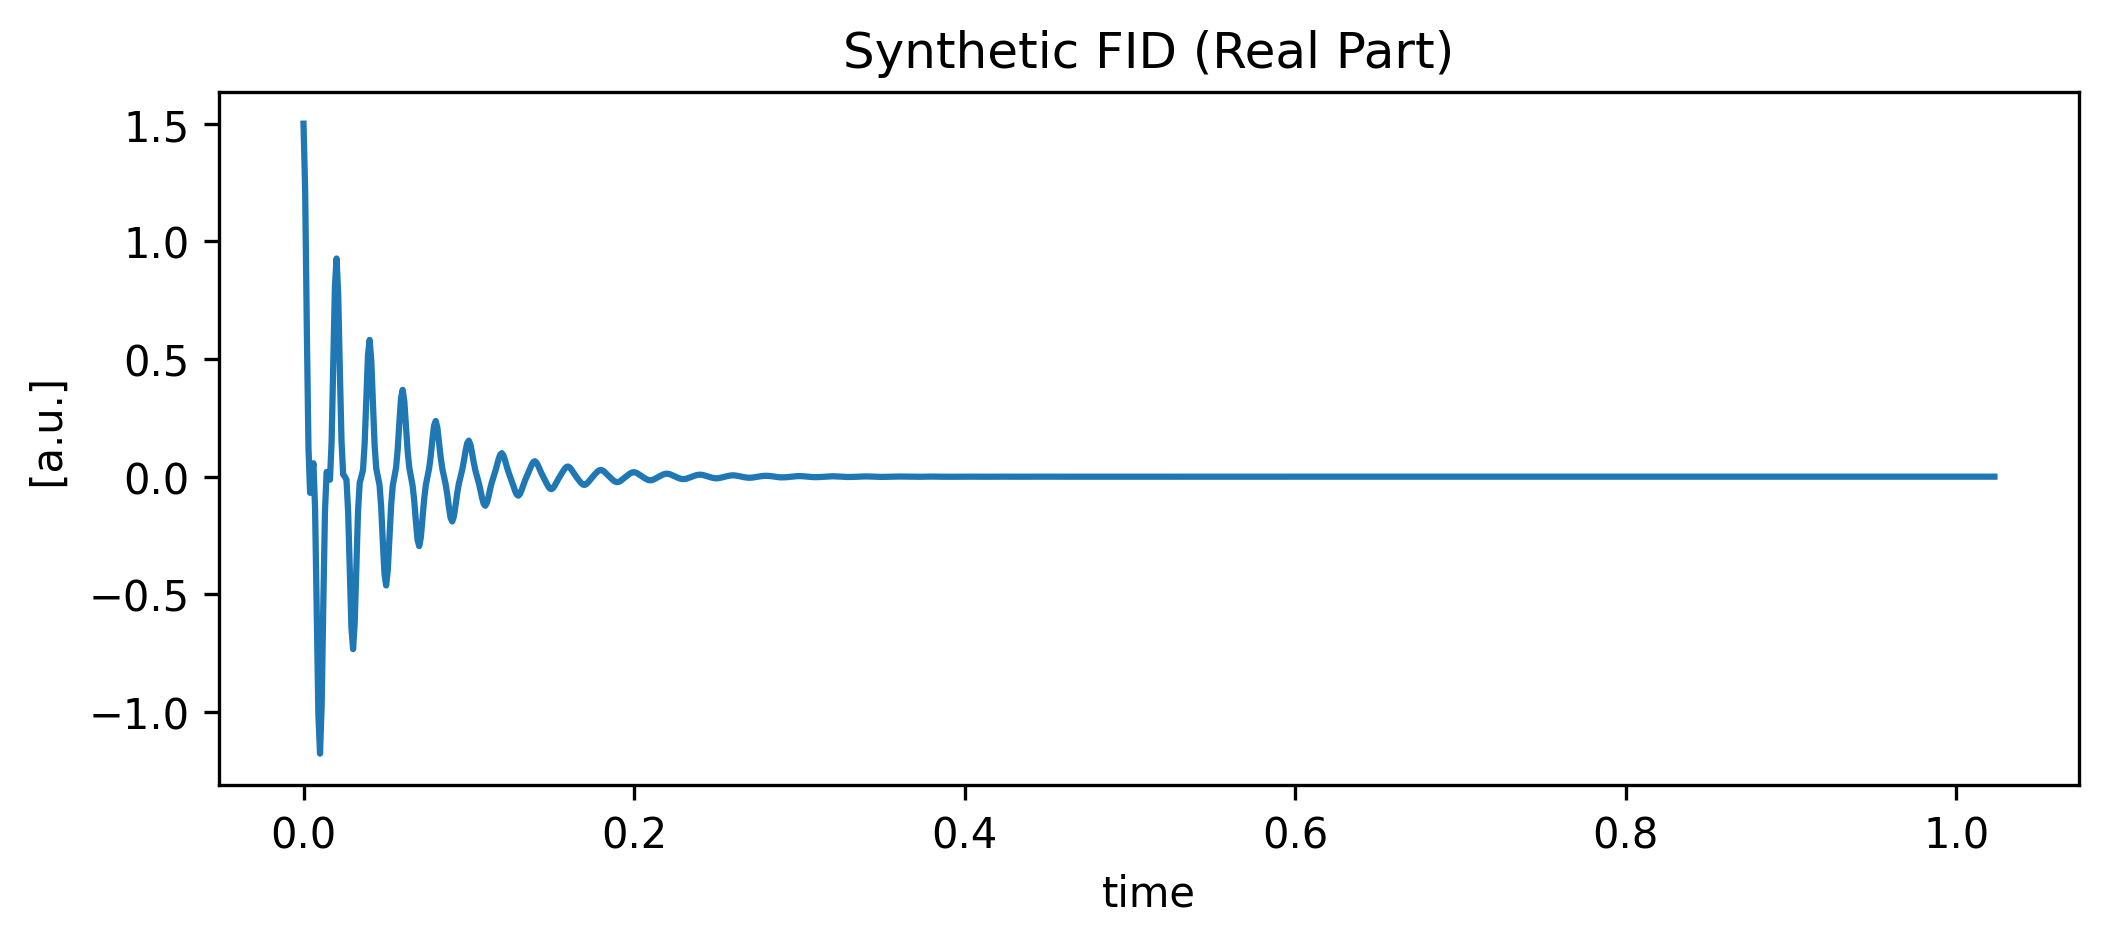

In [3]:
n_points = 1024
dwell_time = 0.001  # 1 ms dwell time implies a spectral width of 1000 Hz
t = np.arange(n_points) * dwell_time

# Two peaks with different frequencies and decay rates
peak1 = np.exp(-t / 0.05) * np.exp(1j * 2 * np.pi * 50 * t)
peak2 = 0.5 * np.exp(-t / 0.03) * np.exp(1j * 2 * np.pi * -150 * t)

da_fid = xr.DataArray(
    peak1 + peak2,
    dims=["time"],
    coords={"time": t},
    attrs={"units": "a.u.", "sequence": "FID", "B0": 3.0},
)

da_fid.real.plot(figsize=(8, 3))
plt.title("Synthetic FID (Real Part)")
plt.show()

## 2. Convert to Spectrum
We use `.xmr.to_spectrum()` to perform the FFT and automatically rename the dimension to "frequency". Notice how the resulting coordinates automatically represent the correct centered frequency axis (ranging from -500 Hz to 500 Hz).

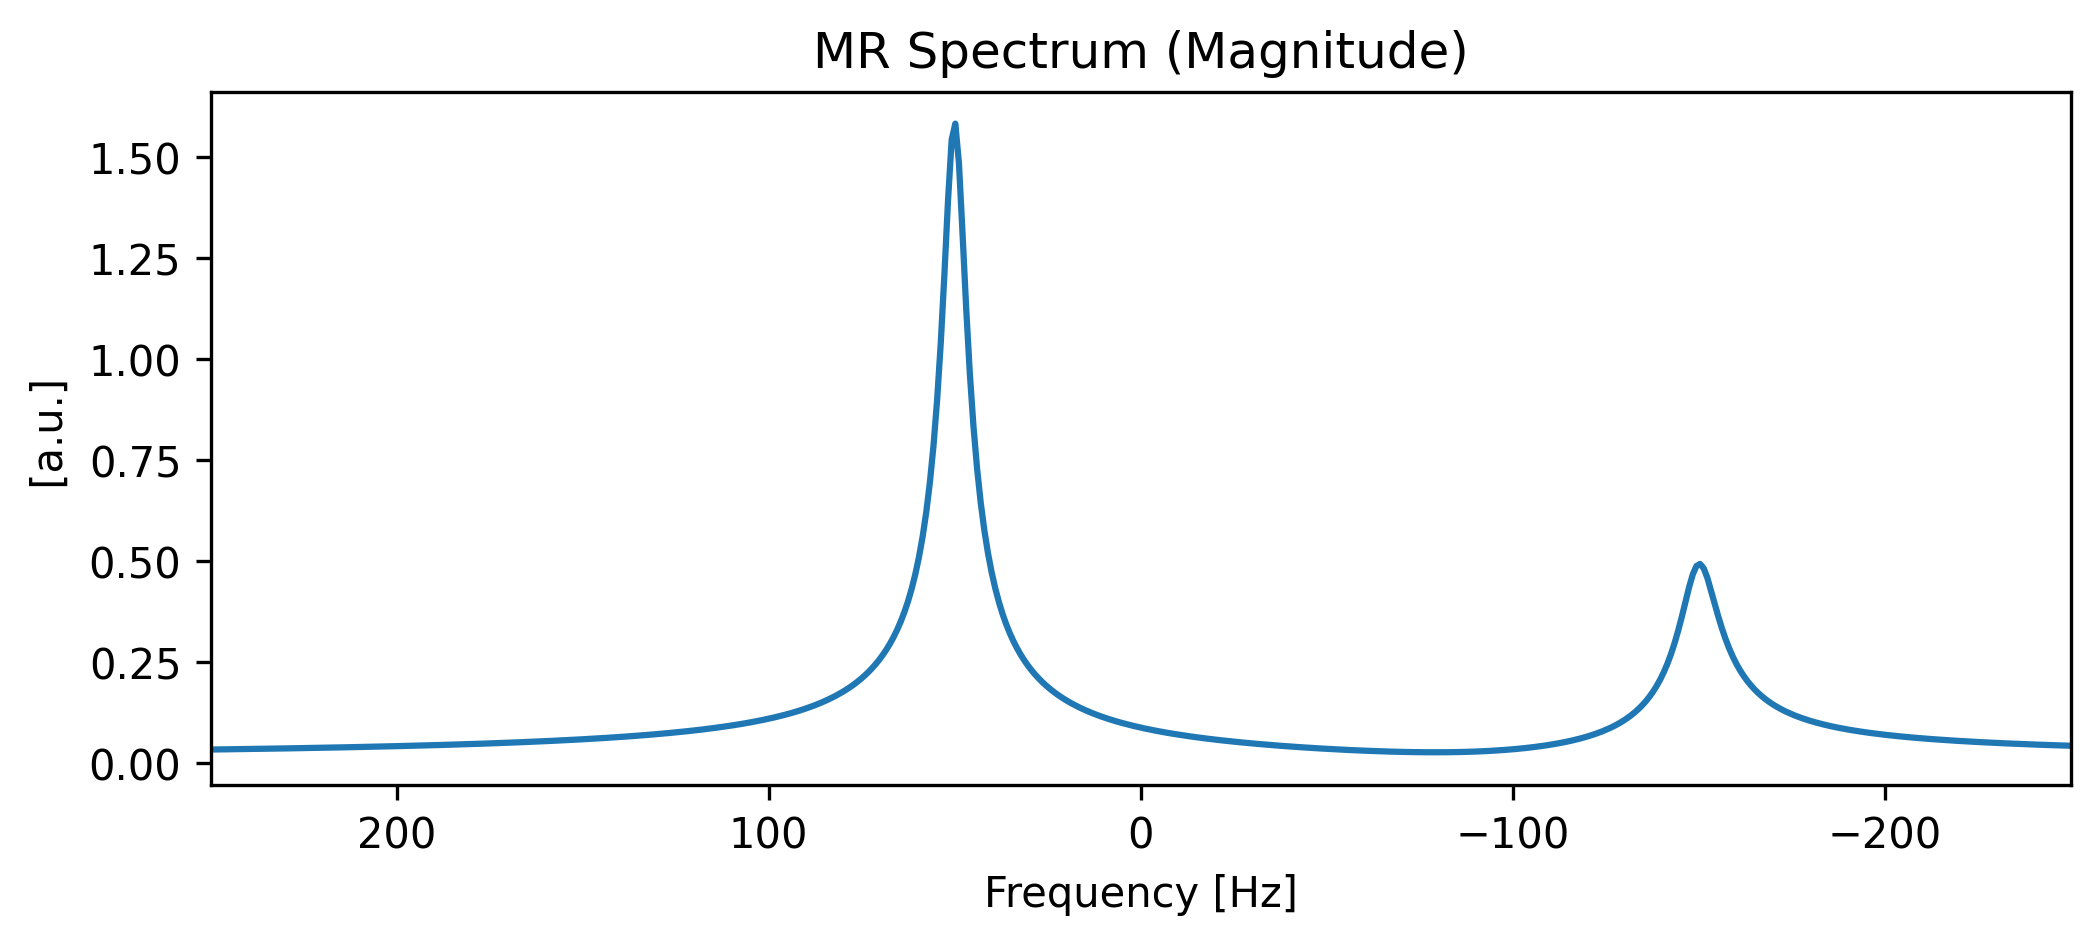

In [4]:
da_spec = da_fid.xmr.to_spectrum(dim="time", out_dim="frequency")

# Plot the magnitude spectrum
np.abs(da_spec).plot(figsize=(8, 3))
plt.title("MR Spectrum (Magnitude)")
plt.xlim(250, -250)  # Standard MRS convention: reverse x-axis
plt.show()

:::{dropdown} Where did that clean "Frequency [Hz]" xlabel come from?

If you spotted that our spectrum has a clean "Frequency [Hz]" xaxis label — even though we never manually assigned it (e.g. with `ax.set_xlabel(...)`) — good eye!

While you can pass simple strings like `"time"` and `"frequency"` to `xmris` functions to keep the entry barrier low, the package internally maps your input against a strict global vocabulary (`xmris.core.config.DIMS` and `COORDS`).

When `.xmr.to_spectrum()` built the new frequency axis, it intercepted your `"frequency"` string, fetched the associated physical metadata (`long_name="Frequency"`, `units="Hz"`), and injected it directly into the new `xarray` coordinates. When you call `.plot()`, `xarray` automatically detects this metadata and formats the axis labels for you!

**Bonus:** Because `"time"` and `"frequency"` are declared default dimensions in `xmris`, we could actually drop the arguments completely and just call `da_fid.xmr.to_spectrum()` for the exact same result!

For more info on this design, see [xmris Architecture: Why We Built It This Way](./architecture.ipynb)
:::

In [5]:
# STRICT TESTS: FID to Spectrum
# 1. Prove metadata preservation
assert "frequency" in da_spec.dims, "Dimension was not renamed."
assert da_spec.attrs == da_fid.attrs, "Attributes were dropped."

# 2. Prove math and coordinate alignment
_expected_freqs = np.fft.fftshift(np.fft.fftfreq(n_points, d=dwell_time))
_expected_spec = np.fft.fftshift(np.fft.fft(da_fid.values, norm="ortho"))

np.testing.assert_allclose(
    da_spec.coords["frequency"].values,
    _expected_freqs,
    err_msg="Frequency coordinates are incorrect.",
)
np.testing.assert_allclose(
    da_spec.values, _expected_spec, err_msg="Spectrum values are incorrect."
)

## 3. Convert back to FID
We can accurately recover the original time-domain signal using `.xmr.to_fid()`.

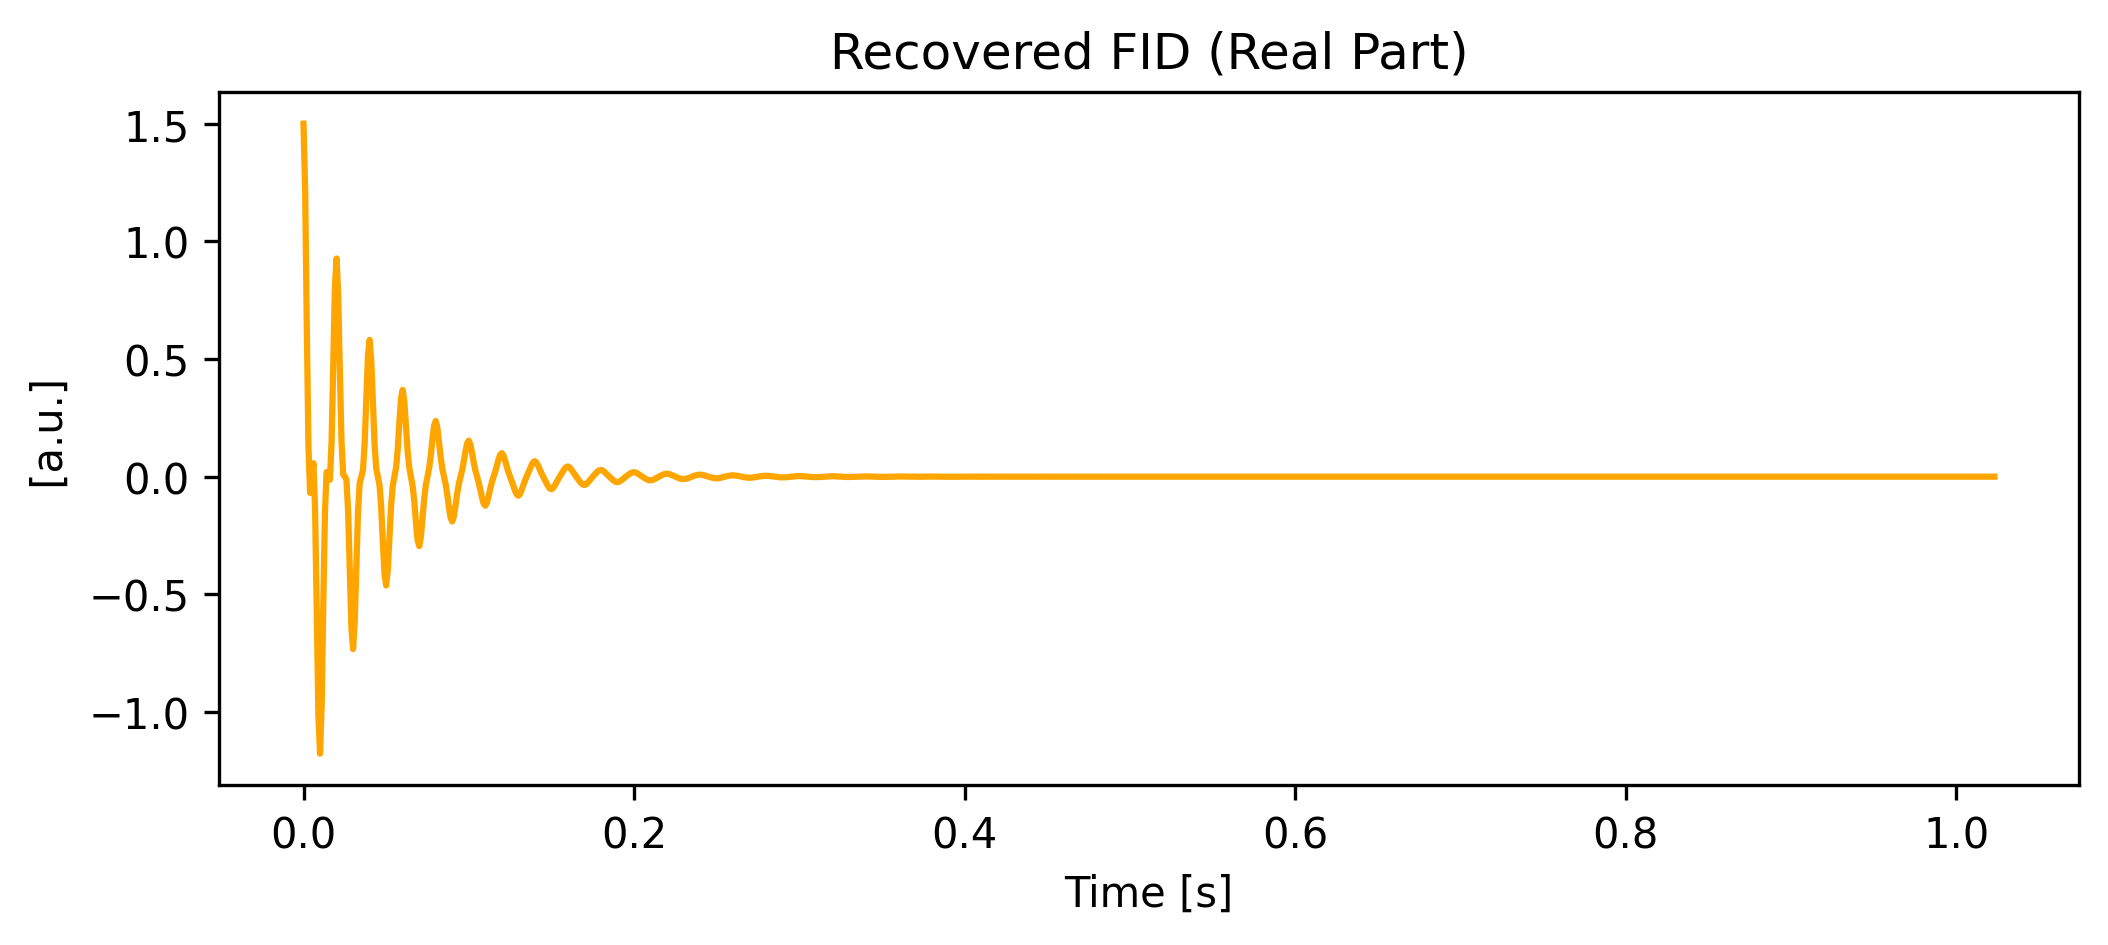

In [6]:
da_recovered = da_spec.xmr.to_fid(dim="frequency", out_dim="time")

da_recovered.real.plot(figsize=(8, 3), linestyle="-", color="orange")
plt.title("Recovered FID (Real Part)")
plt.show()

In [7]:
# STRICT TESTS: Spectrum back to FID
assert "time" in da_recovered.dims, "Dimension was not renamed back to Time."
np.testing.assert_allclose(
    da_recovered.coords["time"].values,
    da_fid.coords["time"].values,
    err_msg="Time coordinates shifted.",
)
np.testing.assert_allclose(
    da_recovered.values,
    da_fid.values,
    err_msg="Data was not accurately recovered.",
    atol=1e-10,
)